<a href="https://colab.research.google.com/github/gunjansa/schoolofai/blob/main/Modular_SchoolOfAISession_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import utils
import model_assignment_5 as model_5
import model_assignment_6 as model_6
import model_assignment_7 as model_7
import trainer

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

CUDA Available? False


device(type='cpu')

CODE BLOCK: 3

In [3]:
train_loader, test_loader = utils.create_mnist_dataloader(512)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5503810.27it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158430.57it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1507565.72it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4174086.06it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


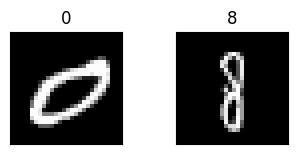

In [4]:
utils.get_dataset_images(train_loader, 2)

In [ ]:
model_mnist_6 = model_6.Net().to(device)
utils.get_model_summary(model_mnist_6, device)

In [ ]:
model_mnist_5 = model.Net().to(device)
utils.get_model_summary(model_mnist_5, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [13]:
class Net1(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net1, self).__init__()
        # RF = RF + (jin * (kernel-1))
        # jin = jin * stride
        # For MaxPool, kernel = 2 and stride = 2
        dropout_value = 0.1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 26, RF = 3, jin=1

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 24, RF = 5, jin=1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6, jin = 2

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10, RF = 10, jin=2

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5, RF = 12, jin = 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 3, RF = 20, jin=4

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 1, RF = 28, jin=4

        # CONV and GAP
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 1, RF = 28

        # OUTPUT BLOCK
        output_size_after_averaging = 1
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size_after_averaging)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.convblock4(x)
        x = self.convblock5(x)

        x = self.convblock6(x)
        x = self.gap(x)

        x = x.view(len(x), 10)

        return F.log_softmax(x, dim=1)

In [14]:
model_mnist_test = Net1().to(device)
utils.get_model_summary(model_mnist_test, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             144
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4            [-1, 8, 34, 34]           1,152
              ReLU-5            [-1, 8, 34, 34]               0
       BatchNorm2d-6            [-1, 8, 34, 34]              16
         MaxPool2d-7            [-1, 8, 17, 17]               0
            Conv2d-8           [-1, 16, 15, 15]           1,152
              ReLU-9           [-1, 16, 15, 15]               0
      BatchNorm2d-10           [-1, 16, 15, 15]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
           Conv2d-12              [-1, 8, 5, 5]           1,152
             ReLU-13              [-1, 8, 5, 5]               0
      BatchNorm2d-14              [-1, 

In [15]:
model_mnist_3 = Net1().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist_3.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train(model_mnist_3, device, train_loader, optimizer, criterion)
  trainer.test(model_mnist_3, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


  0%|          | 0/118 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train: Loss=0.1082 Batch_id=117 Accuracy=89.39: 100%|██████████| 118/118 [01:16<00:00,  1.53it/s]


Test set: Average loss: 0.0002, Accuracy: 9748/10000 (97.48%)

Epoch 2


Train: Loss=0.0981 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9844/10000 (98.44%)

Epoch 3


Train: Loss=0.0330 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9850/10000 (98.50%)

Epoch 4


Train: Loss=0.0407 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [01:14<00:00,  1.58it/s]


Test set: Average loss: 0.0001, Accuracy: 9891/10000 (98.91%)

Epoch 5


Train: Loss=0.0191 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [01:13<00:00,  1.60it/s]


Test set: Average loss: 0.0001, Accuracy: 9897/10000 (98.97%)

Epoch 6


Train: Loss=0.0349 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [01:13<00:00,  1.60it/s]


Test set: Average loss: 0.0001, Accuracy: 9901/10000 (99.01%)

Epoch 7


Train: Loss=0.0046 Batch_id=117 Accuracy=99.41: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9907/10000 (99.07%)

Epoch 8


Train: Loss=0.0022 Batch_id=117 Accuracy=99.42: 100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Test set: Average loss: 0.0001, Accuracy: 9916/10000 (99.16%)

Epoch 9


Train: Loss=0.0115 Batch_id=117 Accuracy=99.47: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9906/10000 (99.06%)

Epoch 10


Train: Loss=0.0480 Batch_id=117 Accuracy=99.56: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9911/10000 (99.11%)

Epoch 11


Train: Loss=0.0146 Batch_id=117 Accuracy=99.58: 100%|██████████| 118/118 [01:13<00:00,  1.60it/s]


Test set: Average loss: 0.0001, Accuracy: 9915/10000 (99.15%)

Epoch 12


Train: Loss=0.0137 Batch_id=117 Accuracy=99.59: 100%|██████████| 118/118 [01:14<00:00,  1.58it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Epoch 13


Train: Loss=0.0144 Batch_id=117 Accuracy=99.64: 100%|██████████| 118/118 [01:13<00:00,  1.60it/s]


Test set: Average loss: 0.0001, Accuracy: 9909/10000 (99.09%)

Epoch 14


Train: Loss=0.1022 Batch_id=117 Accuracy=99.65: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9915/10000 (99.15%)

Epoch 15


Train: Loss=0.0064 Batch_id=117 Accuracy=99.65: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9919/10000 (99.19%)

Epoch 16


Train: Loss=0.0193 Batch_id=117 Accuracy=99.67: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9914/10000 (99.14%)

Epoch 17


Train: Loss=0.0042 Batch_id=117 Accuracy=99.68: 100%|██████████| 118/118 [01:16<00:00,  1.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9914/10000 (99.14%)

Epoch 18


Train: Loss=0.0175 Batch_id=117 Accuracy=99.71: 100%|██████████| 118/118 [01:12<00:00,  1.63it/s]


Test set: Average loss: 0.0001, Accuracy: 9917/10000 (99.17%)

Epoch 19


Train: Loss=0.0096 Batch_id=117 Accuracy=99.71: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9918/10000 (99.18%)

Epoch 20


Train: Loss=0.0203 Batch_id=117 Accuracy=99.70: 100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9916/10000 (99.16%)



In [ ]:
model_mnist_test = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist_test.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train(model_mnist_test, device, train_loader, optimizer, criterion)
  trainer.test(model_mnist_test, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.0627 Batch_id=117 Accuracy=85.13: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]


Test set: Average loss: 0.0001, Accuracy: 9810/10000 (98.10%)

Epoch 2


Train: Loss=0.0496 Batch_id=117 Accuracy=96.95: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]


Test set: Average loss: 0.0001, Accuracy: 9808/10000 (98.08%)

Epoch 3


Train: Loss=0.1060 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Epoch 4


Train: Loss=0.1710 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (98.96%)

Epoch 5


Train: Loss=0.0897 Batch_id=117 Accuracy=98.25: 100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


Test set: Average loss: 0.0001, Accuracy: 9881/10000 (98.81%)

Epoch 6


Train: Loss=0.0856 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:17<00:00,  6.57it/s]


Test set: Average loss: 0.0001, Accuracy: 9897/10000 (98.97%)

Epoch 7


Train: Loss=0.0509 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


Test set: Average loss: 0.0001, Accuracy: 9903/10000 (99.03%)

Epoch 8


Train: Loss=0.0735 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:18<00:00,  6.53it/s]


Test set: Average loss: 0.0000, Accuracy: 9917/10000 (99.17%)

Epoch 9


Train: Loss=0.0275 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


Test set: Average loss: 0.0000, Accuracy: 9931/10000 (99.31%)

Epoch 10


Train: Loss=0.0213 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


Test set: Average loss: 0.0001, Accuracy: 9917/10000 (99.17%)

Epoch 11


Train: Loss=0.0551 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:18<00:00,  6.43it/s]


Test set: Average loss: 0.0000, Accuracy: 9933/10000 (99.33%)

Epoch 12


Train: Loss=0.0305 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


Test set: Average loss: 0.0001, Accuracy: 9912/10000 (99.12%)

Epoch 13


Train: Loss=0.0478 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:17<00:00,  6.57it/s]


Test set: Average loss: 0.0000, Accuracy: 9926/10000 (99.26%)

Epoch 14


Train: Loss=0.0101 Batch_id=117 Accuracy=98.85: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0000, Accuracy: 9935/10000 (99.35%)

Epoch 15


Train: Loss=0.0518 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


Test set: Average loss: 0.0000, Accuracy: 9939/10000 (99.39%)

Epoch 16


Train: Loss=0.0118 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:17<00:00,  6.56it/s]


Test set: Average loss: 0.0000, Accuracy: 9953/10000 (99.53%)

Epoch 17


Train: Loss=0.0412 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Test set: Average loss: 0.0000, Accuracy: 9955/10000 (99.55%)

Epoch 18


Train: Loss=0.1518 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0000, Accuracy: 9954/10000 (99.54%)

Epoch 19


Train: Loss=0.0135 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0000, Accuracy: 9950/10000 (99.50%)

Epoch 20


Train: Loss=0.0084 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0000, Accuracy: 9950/10000 (99.50%)



In [ ]:
model_mnist = model.Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train(model_mnist, device, train_loader, optimizer, criterion)
  trainer.test(model_mnist, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2560 Batch_id=117 Accuracy=49.49: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0006, Accuracy: 9159/10000 (91.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0880 Batch_id=117 Accuracy=93.31: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0002, Accuracy: 9713/10000 (97.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0771 Batch_id=117 Accuracy=96.27: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0002, Accuracy: 9791/10000 (97.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0953 Batch_id=117 Accuracy=96.97: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0001, Accuracy: 9845/10000 (98.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0455 Batch_id=117 Accuracy=97.49: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Test set: Average loss: 0.0001, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0287 Batch_id=117 Accuracy=97.84: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0001, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0347 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1607 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1283 Batch_id=117 Accuracy=98.30: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0001, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0233 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0591 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0001, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0508 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0183 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0001, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0038 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0001, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1008 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0001, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0103 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0000, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0415 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0000, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0087 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0035 Batch_id=117 Accuracy=99.20: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0000, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0254 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Test set: Average loss: 0.0000, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.


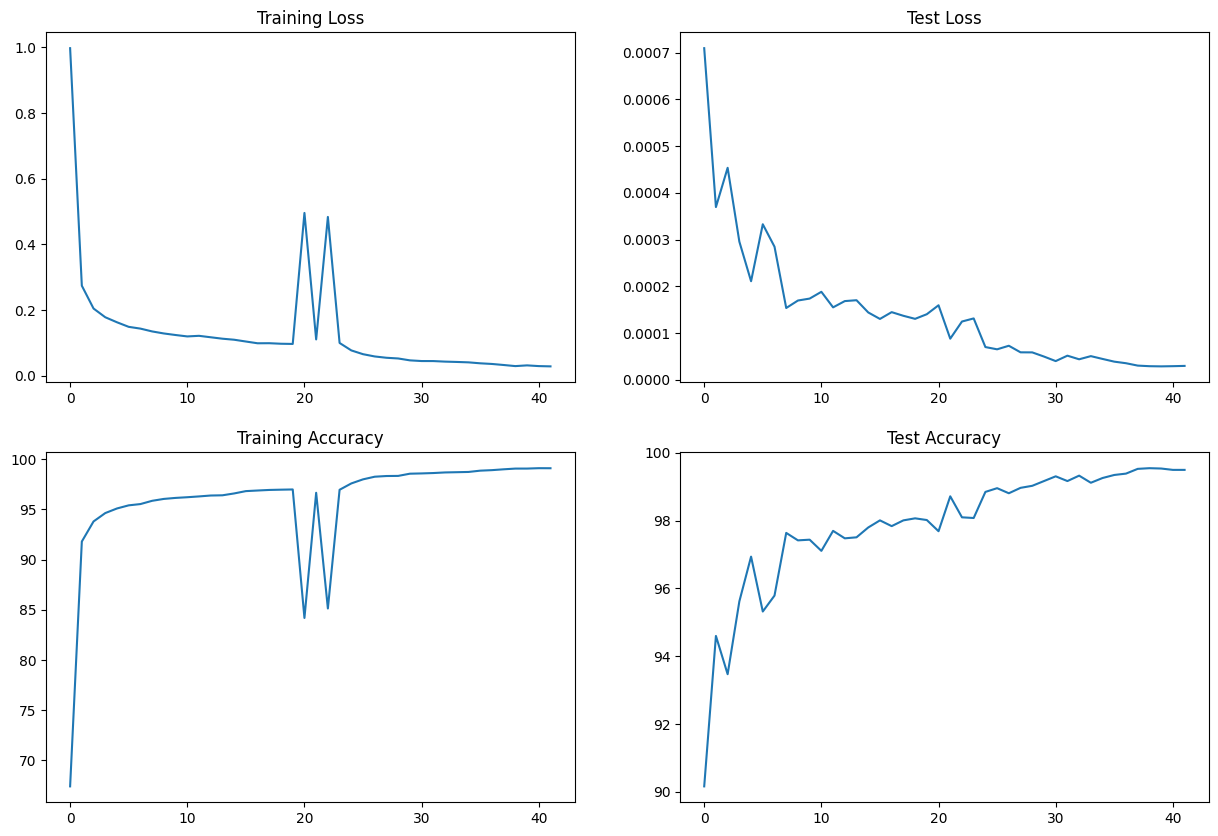

In [ ]:
trainer.draw_graphs()

In [ ]:
utils.get_model_summary(model_mnist, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
